# Project Pokemon datasets Leonardo Pajer

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mplb
import seaborn as sns
from pandas_profiling import ProfileReport
from sklearn import preprocessing
import sklearn as skl
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy import stats
from sklearn.tree import export_graphviz
import pydot

## Data exploration

### Explore the data

In [2]:
pokemon = pd.read_csv(
    "pokemon.csv")

ProfileReport(pokemon, title='Pokemon Profiling Report', explorative=True)

In [3]:
pokemon.describe()

pid          HP      Attack     Defense     Sp. Atk     Sp. Def  \
count  800.0000  800.000000  800.000000  800.000000  800.000000  800.000000   
mean   400.5000   69.258750   79.001250   73.842500   72.820000   71.902500   
std    231.0844   25.534669   32.457366   31.183501   32.722294   27.828916   
min      1.0000    1.000000    5.000000    5.000000   10.000000   20.000000   
25%    200.7500   50.000000   55.000000   50.000000   49.750000   50.000000   
50%    400.5000   65.000000   75.000000   70.000000   65.000000   70.000000   
75%    600.2500   80.000000  100.000000   90.000000   95.000000   90.000000   
max    800.0000  255.000000  190.000000  230.000000  194.000000  230.000000   

            Speed  
count  800.000000  
mean    68.277500  
std     29.060474  
min      5.000000  
25%     45.000000  
50%     65.000000  
75%     90.000000  
max    180.000000

In [4]:
pokemon.skew()

pid          0.000000
HP           1.568224
Attack       0.551614
Defense      1.155912
Sp. Atk      0.744662
Sp. Def      0.854019
Speed        0.357933
Legendary    3.071072
dtype: float64

The Pokedex is composed by 800 Pokemon and 11 characteristics for each of them. The majority of the characteristics is numeric (pid is considered as numeric) so already a constraint for the Random Forest Classifier can be respected. Categorical variables are name, Class1 and Class2. Class 1 and class 2 have 18 distinct classes. As the profile shows, the distribution of pokemon among classes is not equal, that means that some classes are over-represented and some others are under-represented. This could be a problem for the incoming classification task. For what concerns the numeric attributes, the description of the dataset gives us plenty of information: variables mean and IQR are comparable, except variable attack that tends to be, on average, higher then the rest of the variables. However, a difference in the numeric features is represented by the max values, enhanced by the outliers of each distribution. We can see, finally, that distributions are not Normal, since the skew method gives us values different form 0. Moreover, we can say that all distributions present a positive skewness, that is a right tale longer than the left tale. 

### Compare the probability distribution between attack and defense

#### Plot their relationship

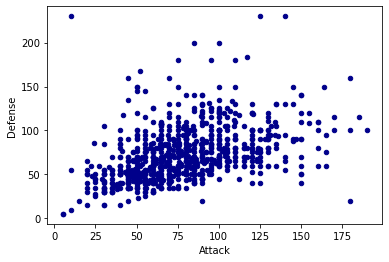

In [5]:
ax1 = pokemon.plot.scatter(x='Attack',
                           y='Defense',
                           c='DarkBlue') # scatterplot attack over defense

In [6]:
# pearson correlation coefficient
print("PearsonrResult",stats.pearsonr(pokemon.Attack, pokemon.Defense))

# spearman correlation coefficient
print(stats.spearmanr(pokemon.Attack, pokemon.Defense))


PearsonrResult (0.4386870551184896, 5.8584798642890344e-39)
SpearmanrResult(correlation=0.5149946056788183, pvalue=2.1597981316449784e-55)


The Pearson correlation coefficient gives us an idea of the linear correlation between two variables. It varies between -1 and 1 where -1 is the perfect negative linear correlation and 1 is the perfect positive linear correlation. In our case the coefficient is 0.43 that suggests a positive correlation between variables. However, the Spearman correlation, that is a non-parametric statistic, suggests us that there are more chances that a monotonic function describes the relation between the variables than a line.  

#### List the names of the 3 Pokémon with highest attack-over-defense ratio

In [7]:
pokemon["A_D"] = pokemon.Attack / pokemon.Defense # create a column that is the attack over defense ratio

pokemon.sort_values(by=["A_D"], ascending=False).head(3)[["Name", "A_D"]] # sort and display pokemon with highest A_D

Name   A_D
429  DeoxysAttack Forme  9.00
347            Carvanha  4.50
19        Mega Beedrill  3.75

#### List the names of the 3 Pokémon with lowest attack-over-defense ratio

In [8]:
pokemon.sort_values(by=["A_D"]).head(3)[["Name", "A_D"]]

Name       A_D
230   Shuckle  0.043478
139  Magikarp  0.181818
484   Bronzor  0.279070

#### List the names of the 10 Pokémon with the largest number of victories

In [9]:
combats = pd.read_csv(
    "combats.csv")

combats["First_win"] = np.where(
    combats['First_pokemon'] == combats["Winner"], True, False) # Create the target column of the Random Forest


combats["pid"] = combats.Winner # change name to easily merge

combats_name = pd.merge(pokemon[["Name", "pid"]], combats, on='pid') # attach name to the dataset 

combats_name["Name"].value_counts().head(10) # display the top ten winners 

Mewtwo                152
Infernape             136
Aerodactyl            136
Jirachi               134
Slaking               133
Deoxys Speed Forme    133
Murkrow               130
Mega Absol            130
Mega Houndoom         128
Mega Aerodactyl       127
Name: Name, dtype: int64

### Professor Oak suspects that Pokémon in the _grass_ class have a stronger regular attack than those in the _rock_ class.

<AxesSubplot:xlabel='Class 1', ylabel='Attack'>

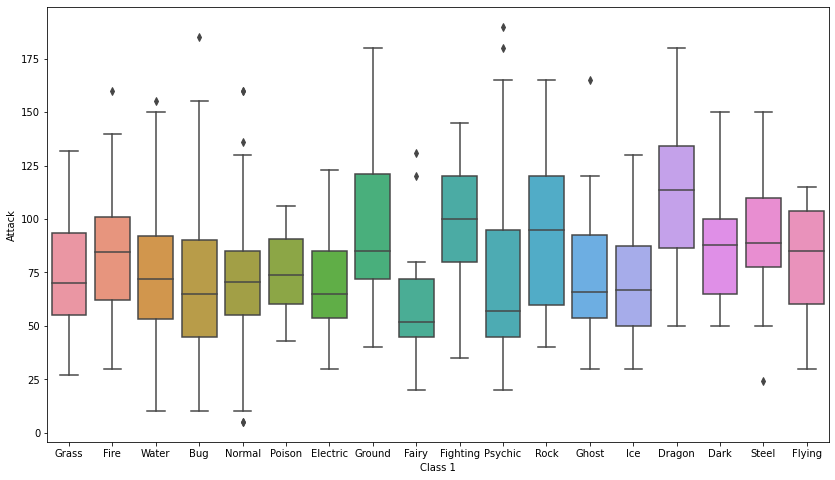

In [10]:
dims = (14, 8)

fig, ax = plt.subplots(figsize=dims)

sns.boxplot(ax=ax, x="Class 1", y="Attack",  data=pokemon)

This Box-plot shows us that grass-class attack  is on average lower then rock attack. This conclusion comes after observing the plot: we can see that the maximum value of Grass class, instead of being comparable to the one of the Rock class, reaches only the top 75 % of the distribution of the Rock class. Moreover, the median value of the Rock class attack is close to the top 75 % of the distribution of the class Grass. That means that, on average, the distribution of Attack values of the Class grass is lower then the Rock one.

## Prediction

### Generate features and label

In [11]:
o_df = pd.read_csv("pokemon.csv", sep=",")
c_df = pd.read_csv("combats.csv", sep=',')

c_df['Loser'] = np.where((c_df['First_pokemon'] != c_df['Winner']) | (
    c_df['Second_pokemon'] != c_df['Winner']), c_df['First_pokemon'], c_df['Second_pokemon']) # define loser

logical_winner_data = pd.merge(
    c_df, o_df, left_on="Winner", right_on="pid", how="left") # merge data of the winner

logical_loser_data = pd.merge(
    c_df, o_df, left_on="Loser", right_on="pid", how="left") # merge loser data 

logical_loser_data.drop(['First_pokemon', 'Second_pokemon',
                         'Winner', 'Loser', 'pid'], axis=1, inplace=True) # drop redundant columns

logical_loser_data.columns = ['Name_loser',
                              'Class 1_loser', 'Class 2_loser', 'HP_loser',
                              'Attack_loser', 'Defense_loser', 'Sp. Atk_loser',
                              'Sp. Def_loser','Speed_loser', 'Legendary_loser'] # define names of columns

logical_winner_data.columns = ['First_pokemon', 'Second_pokemon', 'Winner', 
                               'Loser', 'pid_winner', 'Name_winner',
                               'Class 1_winner', 'Class 2_winner',
                               'HP_winner', 'Attack_winner', 'Defense_winner',
                               'Sp. Atk_winner', 'Sp. Def_winner',
                               'Speed_winner', 'Legendary_winner'] # define nemes of columns


combats_merged = logical_winner_data.join(logical_loser_data) # join prefious datasets together

combats_merged["First_wins"] = np.where(
    combats_merged.Winner == combats_merged.First_pokemon, True, False) # Define the label column

combats_merged # shows the final dataset

First_pokemon  Second_pokemon  Winner  Loser  pid_winner  \
0                266             298     298    266         298   
1                702             701     701    702         701   
2                191             668     668    191         668   
3                237             683     683    237         683   
4                151             231     151    151         151   
...              ...             ...     ...    ...         ...   
49995            707             126     707    707         707   
49996            589             664     589    589         589   
49997            303             368     368    303         368   
49998            109              89     109    109         109   
49999              9              73       9      9           9   

            Name_winner Class 1_winner Class 2_winner  HP_winner  \
0               Nuzleaf          Grass           Dark         70   
1             Terrakion           Rock       Fighting         91   
2              Beheeyem        Psychic            NaN         75   
3             Druddigon         Dragon            NaN         77   
4               Omastar           Rock          Water         70   
...                 ...            ...            ...        ...   
49995          Reshiram         Dragon           Fire        100   
49996           Drilbur         Ground            NaN         60   
49997          Zangoose         Normal            NaN         73   
49998           Voltorb       Electric            NaN         40   
49999  Mega Charizard Y           Fire         Flying         78   

       Attack_winner  ...  Class 1_loser  Class 2_loser  HP_loser  \
0                 70  ...           Rock         Ground        50   
1                129  ...          Grass       Fighting        91   
2                 75  ...          Fairy         Flying        55   
3                120  ...           Fire            NaN        40   
4                 60  ...           Rock          Water        70   
...              ...  ...            ...            ...       ...   
49995            120  ...         Dragon           Fire       100   
49996             85  ...         Ground            NaN        60   
49997            115  ...          Water         Flying        60   
49998             30  ...       Electric            NaN        40   
49999            104  ...           Fire         Flying        78   

       Attack_loser  Defense_loser Sp. Atk_loser Sp. Def_loser Speed_loser  \
0                64             50            45            50          41   
1                90             72            90           129         108   
2                40             85            80           105          40   
3                40             40            70            40          20   
4                60            125           115            70          55   
...             ...            ...           ...           ...         ...   
49995           120            100           150           120          90   
49996            85             40            30            45          68   
49997            50            100            85            70          65   
49998            30             50            55            55         100   
49999           104             78           159           115         100   

       Legendary_loser  First_wins  
0                False       False  
1                 True       False  
2                False       False  
3                False       False  
4                False        True  
...                ...         ...  
49995             True        True  
49996            False        True  
49997            False       False  
49998            False        True  
49999            False        True  

[50000 rows x 26 columns]

In [12]:
combats_rfc = combats_merged[["Attack_winner", "Attack_loser",
                              "HP_winner", "HP_loser",
                              "Defense_winner", "Defense_loser",
                              "Sp. Atk_winner", "Sp. Def_winner",
                              "Sp. Atk_loser", "Sp. Def_loser",
                              "Speed_winner", "Speed_loser",
                              "Class 1_winner", "Class 1_loser",
                              "Legendary_winner", "Legendary_loser", "First_wins"]] # keeps the features that we need

combats_rfc_target = pd.get_dummies(combats_rfc) #transform categorical features in dummy variables for RFC

combats_rfc = combats_rfc_target.drop(['First_wins'], axis=1) # save the label and drop it from the features dataset 

### How does your pokemon handle categorical features and pokemon with 2 classes?

Since RFC does not takes categorical features i decided to one-hot-encode the class feature. Even if creating dummies adds sparsity to the model, it will give us an hint with respect to the importance of the various characteristics of the pokemon in classifying the winner. Pokemon with two classes were included but only being a member of a particular Class 1 became a feature for the Algorithm. This because we could have deleted the pokemon with one class only, but they were more then pokemon with two classes, leading to a reduction of the dataset of more then 50%. 

(Spoiler: anyway class is not particularly important according to RFC so not considering the second class should not be a disaster)

### Train a random forest to predict the winner of a match based on the available features. To do so, split the full dataset randomly into a training set (90%) and a testing set (10%), and try different values of the number of estimators (`n_estimators`, try values 10, 25, 50, 100) and the maximum tree depth (`max_depth`, try values 2, 4, 10). Do this manually, without using any scikit-learn helpers.

In [13]:
combats_rfc_train, combats_rfc_test, first_wins_train, first_wins_test = train_test_split(
    combats_rfc, combats_rfc_target.First_wins, test_size=0.10) # create train and test partitions (0.9,0.1)

feature_list = list(combats_rfc_train.columns) # save the features list for later

feature_list # displays it to check that everything is fine

['Attack_winner',
 'Attack_loser',
 'HP_winner',
 'HP_loser',
 'Defense_winner',
 'Defense_loser',
 'Sp. Atk_winner',
 'Sp. Def_winner',
 'Sp. Atk_loser',
 'Sp. Def_loser',
 'Speed_winner',
 'Speed_loser',
 'Legendary_winner',
 'Legendary_loser',
 'Class 1_winner_Bug',
 'Class 1_winner_Dark',
 'Class 1_winner_Dragon',
 'Class 1_winner_Electric',
 'Class 1_winner_Fairy',
 'Class 1_winner_Fighting',
 'Class 1_winner_Fire',
 'Class 1_winner_Flying',
 'Class 1_winner_Ghost',
 'Class 1_winner_Grass',
 'Class 1_winner_Ground',
 'Class 1_winner_Ice',
 'Class 1_winner_Normal',
 'Class 1_winner_Poison',
 'Class 1_winner_Psychic',
 'Class 1_winner_Rock',
 'Class 1_winner_Steel',
 'Class 1_winner_Water',
 'Class 1_loser_Bug',
 'Class 1_loser_Dark',
 'Class 1_loser_Dragon',
 'Class 1_loser_Electric',
 'Class 1_loser_Fairy',
 'Class 1_loser_Fighting',
 'Class 1_loser_Fire',
 'Class 1_loser_Flying',
 'Class 1_loser_Ghost',
 'Class 1_loser_Grass',
 'Class 1_loser_Ground',
 'Class 1_loser_Ice',
 'Clas

In [14]:
n_estimators = [10, 25, 50, 100] # list of n_estimators
max_depth = [2, 4, 10] # list of max_depth


for estimator in n_estimators: # loop over n_estimators

    for max_d in max_depth: # loop over max_depth

        rf = RandomForestClassifier(
            n_estimators=estimator, max_depth=max_d, class_weight="balanced") # set-up the model
        rf.fit(combats_rfc_train, first_wins_train) # fit the model
        predictions = rf.predict(combats_rfc_test) # predict on new dataset

        conf_matrix = confusion_matrix(predictions, first_wins_test) # create a confusion matrix

        classification_ratio = (
            (conf_matrix[1, 1]+conf_matrix[0, 0])/len(first_wins_test))*100 # extract the classification ratio

        print("With number of estimators = %d and max_depth = %d, the classification ratio is: %d" % (
            estimator, max_d, classification_ratio)) 

rf = RandomForestClassifier(
            n_estimators=50, max_depth=100, class_weight="balanced")
rf.fit(combats_rfc_train, first_wins_train)

With number of estimators = 10 and max_depth = 2, the classification ratio is: 73
With number of estimators = 10 and max_depth = 4, the classification ratio is: 86
With number of estimators = 10 and max_depth = 10, the classification ratio is: 97
With number of estimators = 25 and max_depth = 2, the classification ratio is: 75
With number of estimators = 25 and max_depth = 4, the classification ratio is: 83
With number of estimators = 25 and max_depth = 10, the classification ratio is: 97
With number of estimators = 50 and max_depth = 2, the classification ratio is: 75
With number of estimators = 50 and max_depth = 4, the classification ratio is: 88
With number of estimators = 50 and max_depth = 10, the classification ratio is: 98
With number of estimators = 100 and max_depth = 2, the classification ratio is: 74
With number of estimators = 100 and max_depth = 4, the classification ratio is: 83
With number of estimators = 100 and max_depth = 10, the classification ratio is: 97


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=100, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=50, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

### Comment the results

From the above print list we can see that our model does not vary too much depending on the number of estimators. However,
the max_depth parameter changes totally the classification ratio. A more refined tuning could lead to interesting conclusions. The best level of accuracy was registered with {n_estimator: 25, max_depth: 10} and {n_estimator: 25, max_depth: 10}. However, the approximations made by the CPU and the random state may cover the 1% variance registered with the other max_depth set at 10. 

### Are results misleading?

We saw at the beginning that the distribution of pokemon is not equal amongst classes. This, while sampling, can increase the difference of the classes represented in the train and test split. The result is that there is a loss of information in the fitting procedure, leading to an incorrect prediction. However, 98 % of classification accuracy is a good result since Random Forest Classifier is one of the most robust algorithm in this sense. Another idea to increase the class importance and maybe making a better prediction out of it would be to map the strengths and weaknesses of each class. The result would be that the algorithm could recognize that some classes are strong against some others and vice versa.

### Finally, Professor Oak wants to know what the most predictive features are. Plot feature importance as a bar plot representing the 10 most predictive variables.

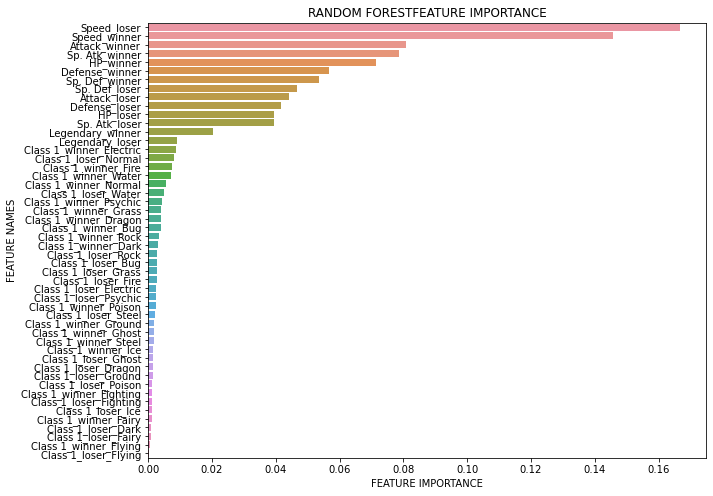

In [15]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

    
    
plot_feature_importance(rf.feature_importances_,combats_rfc_train.columns,'RANDOM FOREST')


We can clearly see that the most important features are Speed, Winner Special attack, life points of the winner and defense of the winner. Classes, as said earlier, are not fundamental with the data prepared in this way.

In [16]:
# Import tools needed for visualization
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Import tools needed for visualization
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file='tree.dot',
                feature_names=feature_list, rounded=True, precision=1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

## Ranking

### Compute the winning ratio (number of wins divided by number of battles) for all Pokémon. Show the 10 Pokémon with the highest ratio and describe what they have in common with respect to their features. Discuss your results about feature importance from question 2.7 (regarding feature importance) in this context.


In [17]:
wins = combats["Winner"].value_counts() # counts number of wins per pokemon


wins = pd.DataFrame(wins)

wins["pid"]=wins.index # save the pid and count for each pokemon

first = combats["First_pokemon"].value_counts() # counts occurrences of a pokemon in the first column

first = pd.DataFrame(first)

first["pid"] = first.index #save pid and count for each pokemon


second = combats["Second_pokemon"].value_counts() # counts occurrences of a pokemon in the first column

second = pd.DataFrame(second)

second["pid"] = second.index # save the pid and count for each pokemon


final = pd.merge(wins,first, on = 'pid') # start merging

final = pd.merge(final,second, on = 'pid') # everything merged now

final["Win_ratio"] = final["Winner"]/(final["Second_pokemon"]+final["First_pokemon"]) # compute win ratio

final = pd.merge(final, pokemon[["Name","pid"]], on = 'pid') # map the name of the pokemon with the pid

final[["Win_ratio","Name"]].head(10) # show result


Win_ratio                Name
0   0.926829              Mewtwo
1   0.964539          Aerodactyl
2   0.912752           Infernape
3   0.875817             Jirachi
4   0.917241  Deoxys Speed Forme
5   0.886667             Slaking
6   0.822785             Murkrow
7   0.935252          Mega Absol
8   0.948148       Mega Houndoom
9   0.984496     Mega Aerodactyl

### A simple method for identifying the strongest Pokémon using this graph is to compute the matrix _A_ = _G_ + _G_<sup>2</sup>. Consider a given row of _A_; summing up all elements of that row results in a dominance score for the respective Pokémon. Explain what this score represents and why it may be interpreted as capturing the dominance of a Pokémon.

In [18]:
winners = dict()

for row in combats.iterrows():
    first = row[1][0]
    second = row[1][1]
    winner = row[1][2]
    if not winner in winners.keys():
        if winner != first:
            winners[second] = [first]
        else:
            winners[first] = [second]
    else:
        if winner != first:
            winners[second].append(first)
        else:
            winners[first].append(second) # computes the dictionary with the list of all the pokemon being 
                                          # defeated by a particular pokemon
winners

{298: [266,
  35,
  781,
  788,
  324,
  113,
  434,
  189,
  645,
  278,
  73,
  434,
  515,
  297,
  227,
  52,
  517,
  620,
  347,
  373,
  640,
  73,
  117,
  45,
  347,
  506,
  360,
  203,
  277,
  191,
  297,
  256,
  668,
  759,
  659,
  53,
  761,
  156,
  759,
  323,
  790,
  761,
  73,
  117,
  317,
  561,
  440,
  757],
 701: [702,
  624,
  169,
  436,
  211,
  97,
  526,
  737,
  799,
  137,
  719,
  22,
  592,
  594,
  555,
  132,
  21,
  34,
  337,
  185,
  441,
  235,
  209,
  179,
  523,
  494,
  397,
  23,
  478,
  733,
  302,
  250,
  736,
  757,
  202,
  342,
  377,
  620,
  255,
  653,
  35,
  374,
  250,
  397,
  710,
  53,
  83,
  56,
  542,
  353,
  213,
  671,
  607,
  457,
  480,
  491,
  541,
  356,
  108,
  456,
  264,
  113,
  475,
  223,
  246,
  202,
  105,
  344,
  744,
  159,
  602,
  395,
  452,
  504,
  136,
  360,
  445,
  500,
  774,
  518,
  375,
  628,
  75,
  652,
  788,
  455,
  493,
  485,
  126,
  161,
  367,
  526,
  648,
  251,
  667,
  776

In [19]:
num_pokemon = len(pokemon.pid) 

df = pd.DataFrame(np.zeros((num_pokemon, num_pokemon)))


for i in range(num_pokemon):
    for j in range(num_pokemon):
        if i+1 not in winners.keys() and j+1 not in winners.keys():
            pass
        elif j+1 not in winners.keys():
            df.iloc[i, j] = 1
        elif i+1 not in winners.keys():
            df.iloc[j, i] = 1
        else:
            if winners[i+1].count(j+1) > winners[j+1].count(i+1):
                df.iloc[i, j] = 1 # compute the dominance matrix

### Compute a and extract the 10 best pokemon

In [20]:
df_2 = np.matmul(df, df) # compute a^2


final_matrix = df + df_2 # sum the dominance matrix a by the square of itself

ranking = final_matrix.sum(axis=1)
ranking.sort_values(ascending=False)


ranking = pd.DataFrame(ranking)

ranking["pid"] = ranking.index + 1

ranking_name = ranking.merge(pokemon[["Name", "pid"]], on="pid")

ranking_name = ranking_name.rename(columns={0: "Score"})

ranking_name.sort_values(by=["Score"], ascending=False).head(10) # display the 10 most dominant pokemon


Score  pid                Name
162  10534.0  163              Mewtwo
431  10016.0  432  Deoxys Speed Forme
153   9657.0  154          Aerodactyl
146   9271.0  147             Jolteon
426   9075.0  427       Mega Rayquaza
248   9031.0  249       Mega Houndoom
154   8976.0  155     Mega Aerodactyl
427   8959.0  428             Jirachi
393   8959.0  394          Mega Absol
429   8956.0  430  DeoxysAttack Forme

The peculiarity of the dominance matrix is that represent a directed graph, that is is not symmetric, and represents only the pokemon on the columns being dominant over pokemon on the rows. By multiplying it by itself, we are increasing the numbers present on the matrix, creating a distribution of the value of each row that is wider then the first one. Not only we are doing this to create a better ranking, but we are also making a sort of transposition of the original matrix. This means that if, originally, it had meaning to count the 1 present in a column to state the general dominance of that pokemon, now it has meaning to sum the values by row. Finally doing the last operation a+a^2 (AND NOT THE OPPOSITE!) we are keeping trace of the original dominance of a particular pokemon, that is, we are reminding to the square matrix with which pokemon a pokemon is dominant. 

### Compare the ranking by dominance scores with the ranking by winning ratio

Ranking are different but not radically. We can state that the ranking made from the winning ratio gives you a better idea of the strength of a pokemon. However it has limitations: If, for example, a pokemon battled with the same pokemon with which it won a lot of times, and few times with pokemon against which it lost, the ratio would be high, even if there are few information about the result with other pokemon. The dominance ranking instead is very robust to the proportion of the battles of a pokemon against others, since it is considering only if a pokemon is dominant (won more direct combats against its the opponent) against all the others.

### Which scoring method is the best one for Professor Oak new pokedex?

Seen the considerations above, the suggestion for Professor Oak is then to adopt the dominance score as new ranking method for the pokedex 2.0. 